### Your very own neural network

In this notebook, we're going to build a neural network using naught but pure numpy and steel nerves. It's going to be fun, I promise!



In [139]:
import sys
import os
import time
from random import randrange
from __future__ import print_function

import numpy as np

np.random.seed(42)

In [140]:
# loading the sdataset
!tar -zxvf MNIST.tar.gz

x MNIST/
x MNIST/raw/
x MNIST/raw/train-labels-idx1-ubyte
x MNIST/raw/t10k-labels-idx1-ubyte.gz
x MNIST/raw/t10k-labels-idx1-ubyte
x MNIST/raw/t10k-images-idx3-ubyte.gz
x MNIST/raw/train-images-idx3-ubyte
x MNIST/raw/train-labels-idx1-ubyte.gz
x MNIST/raw/t10k-images-idx3-ubyte
x MNIST/raw/train-images-idx3-ubyte.gz
x MNIST/processed/
x MNIST/processed/training.pt
x MNIST/processed/test.pt


In [141]:
# adapted from https://github.com/Lasagne/Lasagne/blob/master/examples/mnist.py

import sys
import os
import time
from random import randrange
from __future__ import print_function

import numpy as np

MNIST_PATH = './MNIST/raw'
def load_dataset(flatten=False):
    # We first define a download function, supporting both Python 2 and 3.
    if sys.version_info[0] == 2:
        from urllib import urlretrieve
    else:
        from urllib.request import urlretrieve

    
    # We then define functions for loading MNIST images and labels.
    # For convenience, they also download the requested files if needed.
    import gzip

    def load_mnist_images(filename):
        # Read the inputs in Yann LeCun's binary format.
        with gzip.open(os.path.join(MNIST_PATH, filename), 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        # The inputs are vectors now, we reshape them to monochrome 2D images,
        # following the shape convention: (examples, channels, rows, columns)
        data = data.reshape(-1, 1, 28, 28)
        # The inputs come as bytes, we convert them to float32 in range [0,1].
        # (Actually to range [0, 255/256], for compatibility to the version
        # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        # Read the labels in Yann LeCun's binary format.
        with gzip.open(os.path.join(MNIST_PATH, filename), 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        # The labels are vectors of integers now, that's exactly what we want.
        return data

    # We can now download and read the training and test set images and labels.
    X_train = load_mnist_images('train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    if flatten:
        X_train = X_train.reshape([-1, 28**2])
        X_val = X_val.reshape([-1, 28**2])
        X_test = X_test.reshape([-1, 28**2])


    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [142]:
# some utils we'll need to complete the assignment
def eval_numerical_gradient(f, x, verbose=False, h=0.00001):
    """Evaluates gradient df/dx via finite differences:
    df/dx ~ (f(x+h) - f(x-h)) / 2h
    Adopted from https://github.com/ddtm/dl-course/ (our ysda course).
    """
    fx = f(x) # evaluate function value at original point
    grad = np.zeros_like(x)
    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:

        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # restore

        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h) # the slope
        if verbose:
            print (ix, grad[ix])
        it.iternext() # step to next dimension

    return grad

Here goes our main class: a layer that can .forward() and .backward().

In [143]:
class Layer:
    """
    A building block. Each layer is capable of performing two things:
    
    - Process input to get output:           output = layer.forward(input)
    
    - Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)
    
    Some layers also have learnable parameters which they update during layer.backward.
    """
    def __init__(self):
        """Here you can initialize layer parameters (if any) and auxiliary stuff."""
        # A dummy layer does nothing
        pass
    
    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        """
        # A dummy layer just returns whatever it gets as input.
        return input

    def backward(self, input, grad_output):
        """
        Performs a backpropagation step through the layer, with respect to the given input.
        
        To compute loss gradients w.r.t input, you need to apply chain rule (backprop):
        
        d loss / d x  = (d loss / d layer) * (d layer / d x)
        
        Luckily, you already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.
        
        If your layer has parameters (e.g. dense layer), you also need to update them here using d loss / d layer
        """ 
        # The gradient of a dummy layer is precisely grad_output, but we'll write it more explicitly
        num_units = input.shape[1]
        
        d_layer_d_input = np.eye(num_units)
        
        return np.dot(grad_output, d_layer_d_input) # chain rule

### The road ahead

We're going to build a neural network that classifies MNIST digits. To do so, we'll need a few building blocks:
- Dense layer - a fully-connected layer, $f(X)=X \cdot W + \vec{b}$
- ReLU activation layer: $ReLU(x) = max(0, x)$
- Loss function - cross-entropy: $\mathcal{L} = -\sum_{i=1}^{C} y_i \log(\hat{y}_i),$ where $C$ — number of classification classes, $y_i$ — the correct target value of class i (=1, if the object class is i, and =0 otherwise), $\hat{y}_i$ — the model-predicted probability that the object belongs to class i.
- Backprop algorithm - a stochastic gradient descent with backpropageted gradients

Let's approach them one at a time.


### Nonlinearity layer

This is the simplest layer you can get: it simply applies a nonlinearity to each element of your network.

$ReLU(x) = max(0, x)$

In [144]:
class ReLU(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass
    
    def forward(self, input):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        output = np.maximum(0, input)
        return output
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        relu_grad = input > 0
        return grad_output * relu_grad        

In [145]:
# some tests
x = np.linspace(-1, 1, 10*32).reshape([10, 32])
l = ReLU()
grads = l.backward(x,np.ones([10, 32])/(32 * 10))
numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).mean(), x=x)
assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0),\
    "gradient returned by your layer does not match the numerically computed gradient"


#### Instant primer: lambda functions

In python, you can define functions in one line using the `lambda` syntax: `lambda param1, param2: expression`

For example: `f = lambda x, y: x+y` is equivalent to a normal function:

```
def f(x,y):
    return x+y
```
For more information, click [here](http://www.secnetix.de/olli/Python/lambda_functions.hawk).    

### Dense layer

Now let's build something more complicated. Unlike nonlinearity, a dense layer actually has something to learn.

A dense layer applies affine transformation. In a vectorized form, it can be described as:
$$f(X)= X \cdot W + \vec b $$

Where 
* X is an object-feature matrix of shape [batch_size, num_features],
* W is a weight matrix [num_features, num_outputs] 
* and b is a vector of num_outputs biases.

Both W and b are initialized during layer creation and updated each time backward is called.

In [146]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = <x*W> + b
        """
        self.learning_rate = learning_rate
        
        # initialize weights with small random numbers. 
        self.weights = np.random.randn(input_units, output_units) * 0.01
        self.biases = np.zeros(output_units)
        
    def forward(self, input):
        """
        Perform an affine transformation:
        f(x) = <x*W> + b
        
        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        return np.dot(input, self.weights) + self.biases
    
    def backward(self, input, grad_output):

        # grad_input =  d l / d input
        # d f / d input = weights ^ T
        # grad_output = d l / d f
        # input ^ T = d f / d w
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        # instead of standard python / for division, use np.divide that does !!!element-wise!!! division
        grad_input = np.dot(grad_output, np.transpose(self.weights))
        
        # compute gradient w.r.t. weights and biases
        grad_weights = np.dot(np.transpose(input), grad_output)
        grad_biases = np.sum(grad_output, 0)
        
        print(grad_weights.shape, self.weights.shape)
        assert grad_weights.shape == self.weights.shape # problemo
        assert grad_biases.shape == self.biases.shape
        
        # Here we perform a stochastic gradient descent step. 
        # Later on, you can try replacing that with something better.
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

### Testing the dense layer

Here we have a few tests to make sure your dense layer works properly. You can just run them, get 3 "well done"s and forget they ever existed.

... or not get 3 "well done"s and go fix stuff. If that is the case, here are some tips for you:
* Make sure you compute gradients for W and b as __sum of gradients over batch__, not mean over gradients. Grad_output is already divided by batch size.
* If you're debugging, try saving gradients in class fields, like "self.grad_w = grad_w" or print first 3-5 weights. This helps debugging.
* If nothing else helps, try ignoring tests and proceed to network training. If it trains alright, you may be off by something that does not affect network training.

In [147]:
l = Dense(128, 150)

assert -0.05 < l.weights.mean() < 0.05 and 1e-3 < l.weights.std() < 1e-1,\
    "The initial weights must have zero mean and small variance. "\
    "If you know what you're doing, remove this assertion."
assert -0.05 < l.biases.mean() < 0.05, "Biases must be zero mean. Ignore if you have a reason to do otherwise."

# To test the outputs, we explicitly set weights with fixed values. DO NOT DO THAT IN ACTUAL NETWORK!
l = Dense(3,4)

x = np.linspace(-1,1,2*3).reshape([2,3])
l.weights = np.linspace(-1,1,3*4).reshape([3,4])
l.biases = np.linspace(-1,1,4)

assert np.allclose(l.forward(x),np.array([[ 0.07272727,  0.41212121,  0.75151515,  1.09090909],
                                          [-0.90909091,  0.08484848,  1.07878788,  2.07272727]]))
print("Well done!")

Well done!


In [148]:
# To test the grads, we use gradients obtained via finite differences

x = np.linspace(-1,1,10*32).reshape([10,32])
l = Dense(32,64,learning_rate=0)

numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).sum(),x)
grads = l.backward(x, np.ones([10,64]))

assert np.allclose(grads,numeric_grads,rtol=1e-3,atol=0), "input gradient does not match numeric grad"
print("Well done!")

(32, 64) (32, 64)
Well done!


In [149]:
#test gradients w.r.t. params
def compute_out_given_wb(w,b):
    l = Dense(32,64,learning_rate=1)
    l.weights = np.array(w)
    l.biases = np.array(b)
    x = np.linspace(-1,1,10*32).reshape([10,32])
    return l.forward(x)
    
def compute_grad_by_params(w,b):
    l = Dense(32,64,learning_rate=1)
    l.weights = np.array(w)
    l.biases = np.array(b)
    x = np.linspace(-1,1,10*32).reshape([10,32])
    l.backward(x,np.ones([10,64]) / 10.)
    return w - l.weights, b - l.biases
    
w,b = np.random.randn(32,64), np.linspace(-1,1,64)

numeric_dw = eval_numerical_gradient(lambda w: compute_out_given_wb(w,b).mean(0).sum(),w )
numeric_db = eval_numerical_gradient(lambda b: compute_out_given_wb(w,b).mean(0).sum(),b )
grad_w,grad_b = compute_grad_by_params(w,b)

assert np.allclose(numeric_dw,grad_w,rtol=1e-3,atol=0), "weight gradient does not match numeric weight gradient"
assert np.allclose(numeric_db,grad_b,rtol=1e-3,atol=0), "weight gradient does not match numeric weight gradient"
print("Well done!")

(32, 64) (32, 64)
Well done!



### The loss function

Since we want to predict probabilities, it would be logical for us to define softmax nonlinearity on top of our network and compute loss given predicted probabilities. However, there is a better way to do so.

A standard crossentropy formula

$$CE = -\sum_{i=1}^{C} y_{i} \log(\hat{y}_{i})$$

The softmax output probabilities are computed as follows

$$\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{C} e^{z_j}}$$


If you write down the expression for crossentropy as a function of softmax logits (a), you'll see:

$$ loss = - log \space {e^{a_{correct}} \over {\underset i \sum e^{a_i} } } $$

If you take a closer look, ya'll see that it can be rewritten as:

$$ loss = - a_{correct} + log {\underset i \sum e^{a_i} } $$

It's called Log-softmax and it's better than naive log(softmax(a)) in all aspects:
* Better numerical stability
* Easier to get derivative right
* Marginally faster to compute

So why not just use log-softmax throughout our computation and never actually bother to estimate probabilities.

Here you are! We've defined the both loss functions for you so that you could focus on neural network part.

на последней стадии активируется не relu, a softmax


In [150]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

In [151]:
logits = np.linspace(-1,1,500).reshape([50,10])
answers = np.arange(50)%10

softmax_crossentropy_with_logits(logits,answers)
grads = grad_softmax_crossentropy_with_logits(logits,answers)
numeric_grads = eval_numerical_gradient(lambda l: softmax_crossentropy_with_logits(l,answers).mean(),logits)

assert np.allclose(numeric_grads,grads,rtol=1e-3,atol=0), "The reference implementation has just failed. Someone has just changed the rules of math."

### Full network

Now let's combine what we've just built into a working neural network. As we announced, we're gonna use this monster to classify handwritten digits, so let's get them loaded.

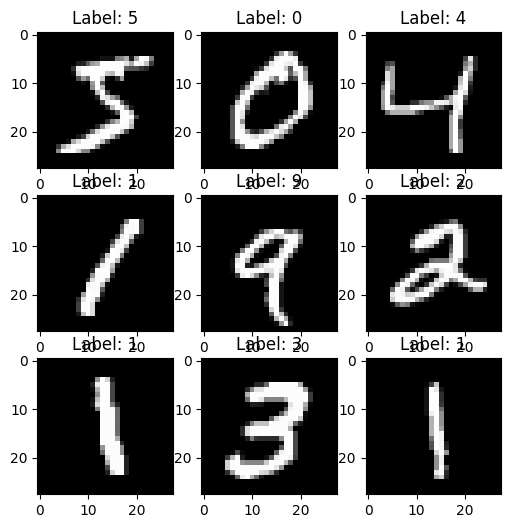

In [152]:
import matplotlib.pyplot as plt
%matplotlib inline

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)

plt.figure(figsize=[6,6])
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

In [153]:
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)

We'll define network as a list of layers, each applied on top of previous one. In this setting, computing predictions and training becomes trivial.

In [154]:
network = []
network.append(Dense(X_train.shape[1], 100)) # первый линейный слой, в нем входные данные. интересны не сами данные, а их размерность
network.append(ReLU())  # активация
network.append(Dense(100, 200)) # второй слой
network.append(ReLU())
network.append(Dense(200, 10)) # последний слой, выходная размерность - 10, тк цифер 10

In [155]:
def forward(network, X):

    activations = [] # выход последней функции
    input = X
    # forward по всему слою, на первом слое вход - input, на остальных - выход предыдущих
    activations.append(network[0].forward(input))
    for i in range(1, len(network)):
        activations.append(network[i].forward(activations[i - 1]))
        
    assert len(activations) == len(network)
    return activations 

def predict(network, X):
    """
    Use network to predict the most likely class for each sample.
    """
    logits = forward(network, X)[-1] # должна быть вероятность принадлежности инпута принадлежать к классу какой-то цифры
    return logits.argmax(axis=-1)

### Backprop

You can now define the backpropagation step for the neural network. Please read the docstring.

In [156]:
def train(network,X,y):
    """
    Train your network on a given batch of X and y.
    You first need to run forward to get all layer activations.
    You can estimate loss and loss_grad, obtaining dL / dy_pred
    Then you can run layer.backward going from last layer to first, 
    propagating the gradient of input to previous layers.
    
    After you called backward for all layers, all Dense layers have already made one gradient step.
    """
    
    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X] + layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y) # l
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y) # 
    
    
    # propagate gradients through network layers using .backward
    # hint: start from last layer and move to earlier layers
    grad = loss_grad
    for i in range(len(network) - 1, -1, -1):
        grad = network[i].backward(layer_inputs[i], grad)

    # d f / d x просчитан в каждом .backward
    # d l / d logits = loss_grad


    # d l / d input = d l / d f * d f / d input
    # 

    # важно - grad_output - только для последнего слоя(logits - выход последнего) - потом loss_grad становится grad_output
        
    return np.mean(loss)

Instead of tests, we provide you with a training loop that prints training and validation accuracies on every epoch.

If your implementation of forward and backward are correct, your accuracy should grow from 90~93% to >97% with the default network.

### Training loop

As usual, we split data into minibatches, feed each such minibatch into the network and update weights.

In [157]:

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for batch_idx in range(int(len(inputs)/batchsize)):        
        start_idx = batch_idx*batchsize
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [158]:
from IPython.display import clear_output
train_log = []
val_log = []

Epoch 24
Train accuracy: 0.99998
Val accuracy: 0.9803


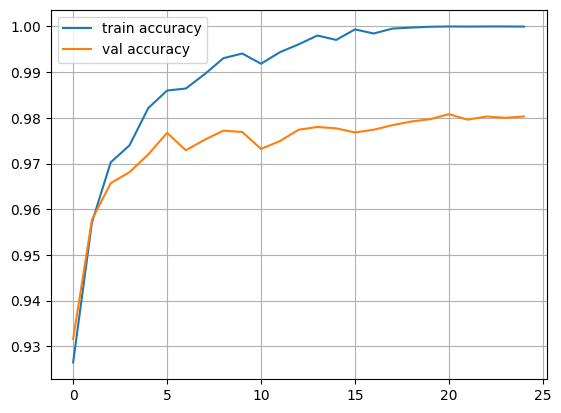

In [159]:
for epoch in range(25):

    for x_batch,y_batch in iterate_minibatches(X_train, y_train, batchsize=32, shuffle=True):
        train(network, x_batch, y_batch)
    
    train_log.append(np.mean(predict(network, X_train) == y_train))
    val_log.append(np.mean(predict(network, X_val) == y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    

__What should you see:__ `train accuracy` should increase to near-100%. Val accuracy will also increase, allbeit to a smaller value.

__What else to try:__ You can try implementing different nonlinearities, dropout or composing neural network of more layers. See how this affects training speed, overfitting & final quality.

Good hunting!

In [160]:
# and yes, it's perfectly legal to reuse your code from this seminar in homework01.

# Let's look at the embeddings

In [161]:
activations = forward(network, X_val)

In [162]:
#layer before the classification, take 1000 samples
f = activations[-2][:1000]
labels = y_val[:1000]
print(f.shape)

(1000, 200)


In [163]:
import scipy.spatial
#compute pairwise distances
d = scipy.spatial.distance_matrix(f,f)

In [164]:
#extract distances for the 'positive pairs' (same class), 
#extract distances for the 'negarite pairs' (different classes), 
a = np.tile(labels.reshape(len(labels), 1), (1, len(labels)))
b =np.tile(labels.reshape(1, len(labels)), (len(labels), 1))
#labels
c = np.zeros((len(labels), len(labels)))
c[a==b]=1
pind =  np.triu(c, k=1)

c = np.zeros((len(labels), len(labels)))
c[a!=b]=1
nind =  np.triu(c, k=1)

print(np.sum(pind), np.sum(nind))
#(5006741.0, 44988259.0) -- for the whole X_val
#(49715.0 449785.0)      -- for X_val[:1000]

pd = d[pind == 1]
nd = d[nind == 1]

49715.0 449785.0


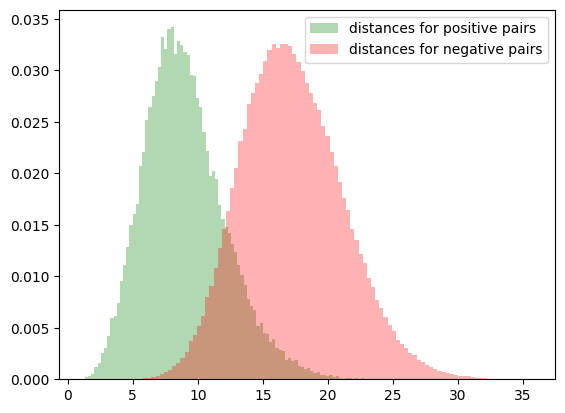

In [165]:
hp,_,_ =plt.hist(pd, bins=100, color='green', alpha = 0.3, weights = np.ones(len(pd))/len(pd), label = 'distances for positive pairs')
hn,_,_ =plt.hist(nd, bins=100, color='red', alpha = 0.3,  weights = np.ones(len(nd))/len(nd),label = 'distances for negative pairs')
plt.legend(loc='best')

The Bhattacharyya coefficient measures an overlap between two statistical samples:
$$  BC(p,q) = \sum (\sqrt{p_i q_i}) $$

In [166]:
#Let's compute the bhattacharyya coefficient
np.sum(np.sqrt(hp*hn))
# 0.8098678769262441 for the whole X_val
# 0.9204532401423291 for X_val[:1000]

np.float64(0.9204532401423291)

(1000, 2)


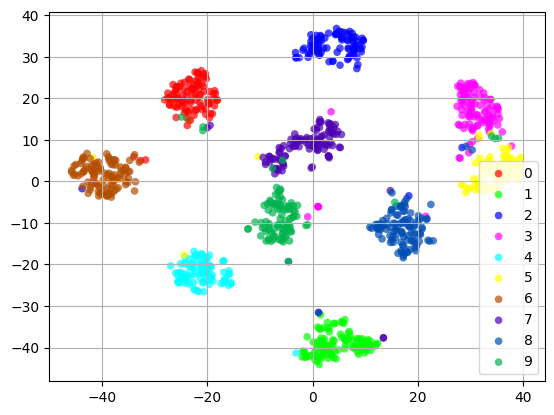

In [167]:
#Look at the t-SNE visualizations: classes are grouped

import sklearn.manifold
import numpy as np
from sklearn.manifold import TSNE
X = np.array(f)
X_embedded = TSNE(n_components=2).fit_transform(X)

print(X_embedded.shape)
coord1 = X_embedded[:,0]
coord2 = X_embedded[:,1]
colors = labels

fig, ax = plt.subplots()

colors = [[1, 0, 0],
          [0, 1, 0],
          [0, 0, 1],
          [1, 0, 1],
          [0, 1, 1],
          [1, 1, 0],
          [0.7, 0.3, 0],
          [0.3, 0, 0.7],
          [0, 0.3, 0.7],
          [0, 0.7, 0.3]
         ]

#np.random.random([len(set(labels)), 3])
for l in set(labels):
    
    coord1_l = coord1[labels == l]
    coord2_l = coord2[labels == l]
    #scale = 200.0 * rand(n)
    ax.scatter(coord1_l, coord2_l, c=[colors[l] for i in range(len(coord1_l))],
               s=30, label=l ,
               alpha=0.7, edgecolors='none')

ax.legend()
ax.grid(True)

plt.show()